# Results of parametric tests

In [1]:
import numpy  as np
import pandas as pd
import time
import os
#%matplotlib notebook
import matplotlib.pyplot as plt

# Particular functions
from numpy import zeros, zeros_like, allclose, where, ones, inf, absolute, linspace, tile, maximum, minimum
from numpy.random import default_rng as rng
from numba import jit
from scipy.spatial.distance import cdist
from scipy.linalg import norm

**Reader**

In [2]:
folder = 'Microscopy_Sized'
path = 'Exact/' + folder + '/'

In [3]:
files = [f[:-9] for f in os.listdir(path) if f.endswith('.txt')]
print('There are', len(files), 'instances in this location:')
display(files)

There are 4 instances in this location:


['data16_1002-data16_1010_p=S2',
 'data8_1002-data8_1010_p=S2',
 'data32_1002-data32_1010_p=S2',
 'data64_1002-data64_1010_p=S2']

In [4]:
instance = files[1]
full_path = path + instance

In [5]:
main_folder = folder + '_Results'
out_folder  = main_folder + '/' + instance
algorithm   = 'PD_Improved'

In [6]:
#df_collected = pd.read_excel(out_folder+'Critical.xlsx', index_col=0)
df_collected = pd.read_csv(out_folder+'Critical_(τ,σ,ρ,γ).csv.gz', index_col=0)
df_collected.describe()

,τ,σ,ρ,γ,its,dist_obj,time
count,1.080000e+06,1.080000e+06,1.080000e+06,1.080000e+06,1.080000e+06,1.080000e+06,1.080000e+06
mean,2.550721e+01,2.550721e+01,1.000000e+00,1.000483e+00,1.248904e+03,5.562842e-01,7.265007e-02
std,3.265553e+01,3.265553e+01,7.071071e-01,5.872761e-01,8.135885e+00,4.680791e-01,2.088933e+00
min,5.917160e-05,5.917160e-05,1.370465e-03,1.000000e-03,1.200000e+01,1.306457e-09,7.393360e-04
25%,5.437351e-03,5.437351e-03,2.928932e-01,5.007500e-01,1.249000e+03,1.210390e-02,6.951284e-02
50%,1.213018e+00,1.213018e+00,1.000000e+00,1.000250e+00,1.249000e+03,9.362696e-01,6.980181e-02
75%,5.050000e+01,5.050000e+01,1.707107e+00,1.500250e+00,1.249000e+03,1.000000e+00,7.062149e-02
max,1.000000e+02,1.000000e+02,1.998630e+00,2.000000e+00,1.249000e+03,1.000000e+00,2.087963e+03


## ```8x8```

Observing the relative objective distance to the true objective, we find that many tests reached a distance smaller than the threshold of ```1e-7```:

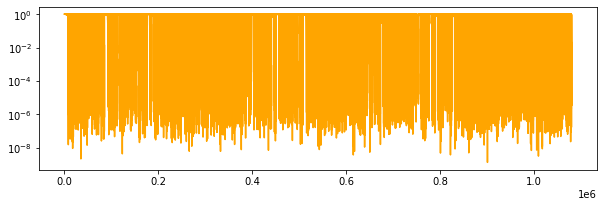

In [7]:
plt.figure(figsize = (10,3));    df_collected['dist_obj'].plot(c='orange');    plt.yscale('log');    plt.show()

If we run 
```Python
    int(df_collected[df_collected['dist_obj'] <= 1e-7].describe()['its'].max())
```
we can find that the tests reaching values below the prescribed threshold are actually the tests that finished before the iteration limit.

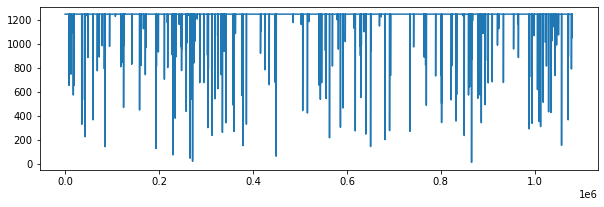

In [8]:
plt.figure(figsize = (10,3));    df_collected['its'].plot();    plt.show()

This allows us to reduce the number of observations substantially.

In [9]:
df_1249 = df_collected[df_collected['its'] < 1249]
df_1249.describe()

,τ,σ,ρ,γ,its,dist_obj,time
count,221.000000,221.000000,221.000000,221.000000,221.000000,2.210000e+02,221.000000
mean,0.011327,60.280543,1.328425,1.020029,777.769231,5.188848e-08,0.043698
std,0.030512,25.897930,0.628083,0.177667,319.254011,2.821381e-08,0.017936
min,0.000263,2.000000,0.012312,0.357964,12.000000,1.306457e-09,0.000739
25%,0.003864,40.000000,0.843566,1.000000,544.000000,2.922566e-08,0.030850
50%,0.007306,64.000000,1.544639,1.000500,821.000000,5.351259e-08,0.046336
75%,0.010529,82.000000,1.891007,1.000500,1021.000000,7.462718e-08,0.057340
max,0.426036,100.000000,1.998630,2.000000,1248.000000,9.926724e-08,0.070920


Running
```
    int(df_1249.drop_duplicates(subset=['τ','σ']).describe().iloc[0,0])
```
We can further observe that there are 78 pairs of values $(\tau,\sigma) \in \Theta_2$ for which more than one value of $\rho$ resulted in a _successful_ test.

In [10]:
df_1249[df_1249.duplicated(subset=['τ','σ','ρ'])].describe().iloc[0,0]

2.0

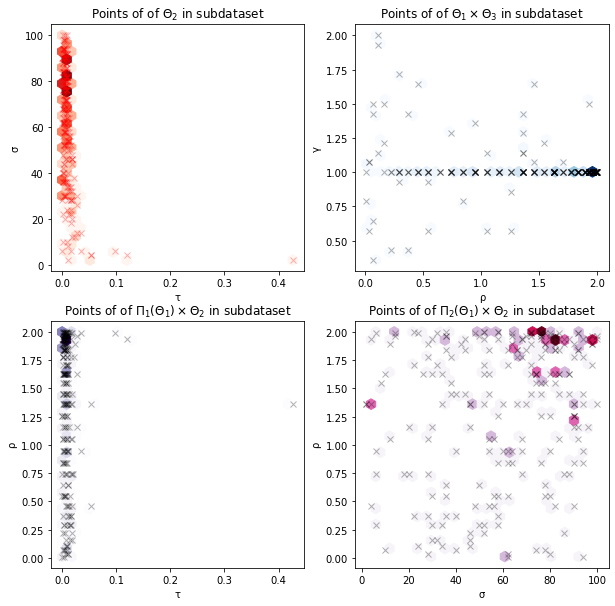

In [11]:
# Visualise grids
plt.figure(figsize = (10,10))

plt.subplot(2, 2, 1)
plt.title(r'Points of of $\Theta_2$ in subdataset')
plt.plot(df_1249['τ'],df_1249['σ'],'x',color='red',alpha=0.3)
plt.hexbin(df_1249['τ'], df_1249['σ'], gridsize=25, cmap='Reds',mincnt=1)
plt.xlabel('τ');    plt.ylabel('σ');

plt.subplot(2, 2, 2)
plt.title(r'Points of of $\Theta_1 \times \Theta_3$ in subdataset')
plt.plot(df_1249['ρ'], df_1249['γ'],'x', color='black', alpha=0.3)
plt.xlabel('ρ');    plt.ylabel('γ');
plt.hexbin(df_1249['ρ'], df_1249['γ'], gridsize=25, cmap='Blues',mincnt=1)
#plt.hist2d(df_1249['ρ'], df_1249['γ'],bins=40, cmap='Blues')
#plt.yticks([], [])
plt.subplot(2, 2, 3)
plt.title(r'Points of of $\Pi_1(\Theta_1) \times \Theta_2$ in subdataset')
plt.plot(df_1249['τ'], df_1249['ρ'],'x', color='black', alpha=0.3)
plt.xlabel('τ');    plt.ylabel('ρ');
plt.hexbin(df_1249['τ'], df_1249['ρ'], gridsize=25, cmap='Purples',mincnt=1)

plt.subplot(2, 2, 4)
plt.title(r'Points of of $\Pi_2(\Theta_1) \times \Theta_2$ in subdataset')
plt.plot(df_1249['σ'], df_1249['ρ'],'x', color='black', alpha=0.3)
plt.xlabel('σ');    plt.ylabel('ρ');
plt.hexbin(df_1249['σ'], df_1249['ρ'], gridsize=25, cmap='PuRd',mincnt=1)


plt.show()

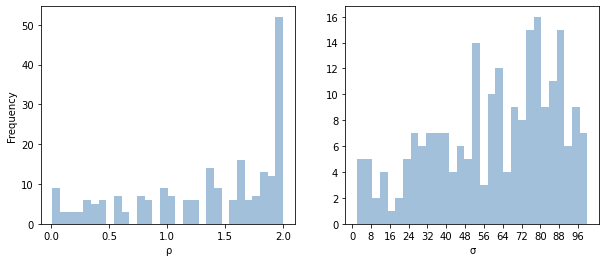

In [12]:
plt.figure(figsize = (10,4))

plt.subplot(1, 2, 1)
plt.hist(df_1249['ρ'], bins=30, alpha=0.5,
         histtype='stepfilled', color='steelblue',
         edgecolor='none');
plt.xlabel('ρ');    plt.ylabel('Frequency');

plt.subplot(1, 2, 2)
plt.hist(df_1249['σ'], bins=30, alpha=0.5,
         histtype='stepfilled', color='steelblue',
         edgecolor='none');
plt.xticks(np.arange(0, max(df_1249['σ']), 8));
plt.xlabel('σ');

plt.plot();

If we plot other parameters against $\gamma$, we can see that there is a trend towards the value of one. Something similar occurs with $\tau$, most good results are whenever it takes a value lower than $10^{-2}$. In terms of $\sigma$, we observe that a value in $[60,100]$ seems to be yielding good results, but there's a change that a lower value might yield good results. In general, the best results are for the subinterval $[76,82]$. For $\rho$, any value not very close to $0$ may yield a fair result, however, from the histogram we can tell that the limit value $\rho = 1.99863$ gives the best behaviour.

We could check if there is any relationship between the values of $\rho$ and $\sigma$ for the smallest attained differences:

In [13]:
A = df_1249[df_1249['τ'] <= 0.01]
A.describe()

,τ,σ,ρ,γ,its,dist_obj,time
count,160.000000,160.000000,160.000000,160.000000,160.000000,1.600000e+02,160.000000
mean,0.005394,69.100000,1.386189,0.996294,788.256250,5.215750e-08,0.044267
std,0.002812,21.585926,0.606554,0.171960,312.045781,2.816137e-08,0.017510
min,0.000263,6.000000,0.012312,0.357964,47.000000,3.114583e-09,0.002667
25%,0.002879,57.500000,0.947664,1.000000,541.750000,2.914268e-08,0.030725
50%,0.005347,75.000000,1.629320,1.000500,829.500000,5.403918e-08,0.046543
75%,0.008054,86.000000,1.891007,1.000500,1027.500000,7.332534e-08,0.057495
max,0.009944,100.000000,1.998630,2.000000,1248.000000,9.861630e-08,0.070164


In [14]:
A[A.duplicated(subset=['τ','σ','ρ'])].describe().iloc[0,0]

2.0

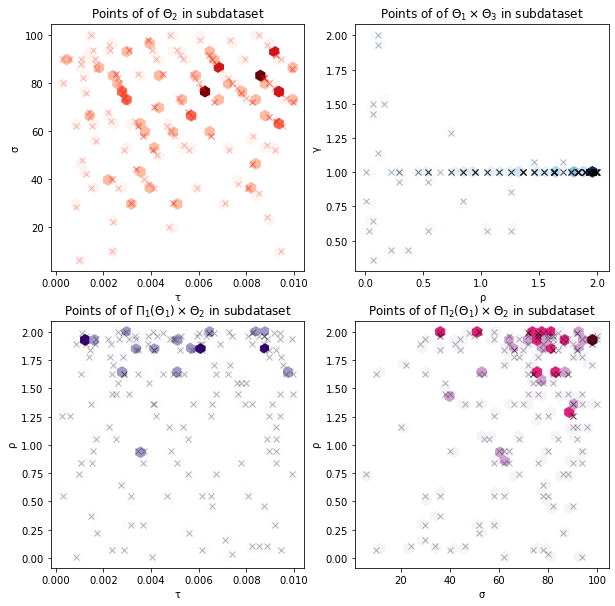

In [15]:
# Visualise grids
plt.figure(figsize = (10,10))

plt.subplot(2, 2, 1)
plt.title(r'Points of of $\Theta_2$ in subdataset')
plt.plot(A['τ'],A['σ'],'x',color='red',alpha=0.3)
plt.hexbin(A['τ'], A['σ'], gridsize=25, cmap='Reds',mincnt=1)
plt.xlabel('τ');    plt.ylabel('σ');

plt.subplot(2, 2, 2)
plt.title(r'Points of of $\Theta_1 \times \Theta_3$ in subdataset')
plt.plot(A['ρ'], A['γ'],'x', color='black', alpha=0.3)
plt.xlabel('ρ');    plt.ylabel('γ');
plt.hexbin(A['ρ'], A['γ'], gridsize=25, cmap='Blues',mincnt=1)

plt.subplot(2, 2, 3)
plt.title(r'Points of of $\Pi_1(\Theta_1) \times \Theta_2$ in subdataset')
plt.plot(A['τ'], A['ρ'],'x', color='black', alpha=0.3)
plt.xlabel('τ');    plt.ylabel('ρ');
plt.hexbin(A['τ'], A['ρ'], gridsize=25, cmap='Purples',mincnt=1)

plt.subplot(2, 2, 4)
plt.title(r'Points of of $\Pi_2(\Theta_1) \times \Theta_2$ in subdataset')
plt.plot(A['σ'], A['ρ'],'x', color='black', alpha=0.3)
plt.xlabel('σ');    plt.ylabel('ρ');
plt.hexbin(A['σ'], A['ρ'], gridsize=25, cmap='PuRd',mincnt=1)


plt.show()

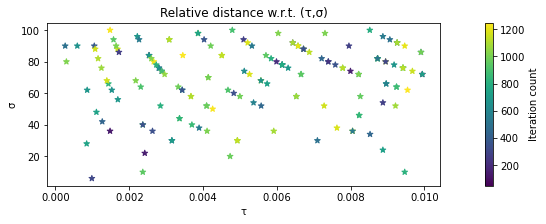

In [16]:
plt.figure(figsize = (8,3))

plt.title(r'Relative distance w.r.t. (τ,σ)')
sc = plt.scatter(A['τ'],A['σ'], marker='*', c=A['its'])
plt.colorbar(sc,fraction=0.02, pad=0.1,label='Iteration count')
plt.xlabel('τ');    plt.ylabel('σ');

plt.show()

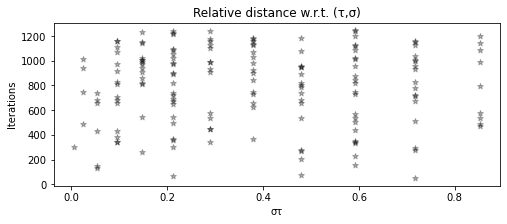

In [24]:
plt.figure(figsize = (8,3))

plt.title(r'Relative distance w.r.t. (τ,σ)')
sc = plt.scatter(A['τ']*A['σ'], A['its'], marker='*',color='black',alpha=0.3)
#plt.hexbin(A['τ']*A['σ'], A['its'], gridsize=25, cmap='Reds',mincnt=1)
plt.xlabel('στ');    plt.ylabel('Iterations');

plt.show()

In [18]:
A.describe()

,τ,σ,ρ,γ,its,dist_obj,time
count,160.000000,160.000000,160.000000,160.000000,160.000000,1.600000e+02,160.000000
mean,0.005394,69.100000,1.386189,0.996294,788.256250,5.215750e-08,0.044267
std,0.002812,21.585926,0.606554,0.171960,312.045781,2.816137e-08,0.017510
min,0.000263,6.000000,0.012312,0.357964,47.000000,3.114583e-09,0.002667
25%,0.002879,57.500000,0.947664,1.000000,541.750000,2.914268e-08,0.030725
50%,0.005347,75.000000,1.629320,1.000500,829.500000,5.403918e-08,0.046543
75%,0.008054,86.000000,1.891007,1.000500,1027.500000,7.332534e-08,0.057495
max,0.009944,100.000000,1.998630,2.000000,1248.000000,9.861630e-08,0.070164


---

```Python
# Plot each parameter and resulting distance (coloured)
fig = plt.figure(figsize = (10,8))
ax = fig.add_subplot(projection='3d')

sc = ax.scatter(df_1999['τ'], df_1999['σ'], df_1999['ρ'], marker='^', c=df_1999['dist_obj'])

ax.set_xlabel('τ')
ax.set_ylabel('σ')
ax.set_zlabel('ρ')
plt.colorbar(sc,fraction=0.02, pad=0.2,label='Relative distance')

plt.show()
```